In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import tree

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D  
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib import pyplot as plt

from plotly.subplots import make_subplots

import plotly.colors as pc



In [2]:
data = pd.read_csv('./Dataset_dumarey/original_csv/Complete.csv')


# Dataset overview

In [3]:
data.head()


vin         timestamp          end_time         odo    end_odo  \
0   -8.99632E+l8  01/01/2021 20:31  01/01/2021 20:38  4436640625  443946875   
1  -8.99632E+ 18   01/01/202120:39   02/01/202115:13   443946875  443946875   
2   -8.99632E+18   02/01/202115:13   02/01/202115:21   443946875    444,250   
3   -8.99632E+18   02/01/202115:21   02/01/202117:46     444,250   445,7125   
4   -8.99632E+18   02/01/202117:46   02/01/202117:53    445,7125    446,145   

     soc  end_soc   event charge_mode  
0  564.0    549.0    trip         NaN  
1  549.0    100.0  charge         240  
2  100.0    100.0    trip         NaN  
3  100.0    945.0    trip         NaN  
4  945.0    945.0    trip         NaN

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   vin          256 non-null    object 
 1   timestamp    256 non-null    object 
 2   end_time     256 non-null    object 
 3   odo          256 non-null    object 
 4   end_odo      256 non-null    object 
 5   soc          253 non-null    float64
 6   end_soc      255 non-null    float64
 7   event        256 non-null    object 
 8   charge_mode  51 non-null     object 
dtypes: float64(2), object(7)
memory usage: 18.1+ KB


# Data Cleaning


In [5]:
def substitute_comma(ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts).strip()
    ts = ts.replace(",", ".")     
    ts = ts.replace(", ", ".")
    ts = ts.replace(" , ", ".")    
    ts = ts.replace(" ,", ".")       
    ts = ts.replace(". ", ".")    
    ts = ts.replace(" .", ".") 
    ts = ts.replace(" . ", ".")       
    return ts 
def remove_comma(ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts).strip()
    ts = ts.replace(",", "")         
    ts = ts.replace(". ", "")        
    ts = ts.replace(".", "")     
    return ts 

def remove_spaces(ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts).strip()
    ts = ts.replace(" ", "")         
    ts = ts.replace("  ", "")        
    ts = ts.replace("   ", "")     
    return ts
def fix_timestamp_format(ts):
    if pd.isna(ts):
        return ts
    
    ts = str(ts).replace(" ", "")  
    
    if len(ts) >= 15:  # es. 27/04/202121:27
        return ts[:10] + ' ' + ts[10:]
    else:
        return ts
def fix_soc (ts):
    if ts > 100.0:
        return ts / 10
    else:
        return ts
def fix_odo(ts):
    if pd.isna(ts):
        return ts
    try:
        ts_str = str(int(ts))
        if len(ts_str) <= 4:
            return int(ts_str) 
        return float(ts_str[:4] + '.' + ts_str[4:])
    except:
        return ts
def fix_vin (ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts)
    if ts.startswith('-8.9'):
        return '1.0'
    elif ts.startswith('-2.4'):
        return '2.0'
    elif ts.startswith('·2.4'):
        return '2.0'
    else:
        return ts


#### Fixing marks

In [6]:
data['odo'] = data['odo'].apply(remove_comma)
data['end_odo'] = data['end_odo'].apply(remove_comma)
data['soc'] = data['soc'].apply(substitute_comma)
data['end_soc'] = data['end_soc'].apply(substitute_comma)

In [7]:
data.head()

vin         timestamp          end_time         odo    end_odo  \
0   -8.99632E+l8  01/01/2021 20:31  01/01/2021 20:38  4436640625  443946875   
1  -8.99632E+ 18   01/01/202120:39   02/01/202115:13   443946875  443946875   
2   -8.99632E+18   02/01/202115:13   02/01/202115:21   443946875     444250   
3   -8.99632E+18   02/01/202115:21   02/01/202117:46      444250    4457125   
4   -8.99632E+18   02/01/202117:46   02/01/202117:53     4457125     446145   

     soc end_soc   event charge_mode  
0  564.0   549.0    trip         NaN  
1  549.0   100.0  charge         240  
2  100.0   100.0    trip         NaN  
3  100.0   945.0    trip         NaN  
4  945.0   945.0    trip         NaN

#### From object to float64


In [8]:
cols_to_float = ['odo', 'end_odo', 'soc', 'end_soc']
for col in cols_to_float:
    data[col] = pd.to_numeric(data[col], errors='coerce')

#### Fixing timestamp format

In [9]:
data['timestamp'] = data['timestamp'].apply(fix_timestamp_format)
data['end_time'] = data['end_time'].apply(fix_timestamp_format) 
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce', dayfirst=True)
data['end_time'] = pd.to_datetime(data['end_time'], errors='coerce', dayfirst=True)

#### Value correction

In [10]:
data['soc'] = data['soc'].apply(fix_soc)
data['end_soc'] = data['end_soc'].apply(fix_soc)
data['odo'] = data['odo'].apply(fix_odo)
data['end_odo'] = data['end_odo'].apply(fix_odo)


In [11]:
data.head()

vin           timestamp            end_time          odo  \
0   -8.99632E+l8 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625   
1  -8.99632E+ 18 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750   
2   -8.99632E+18 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750   
3   -8.99632E+18 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000   
4   -8.99632E+18 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000   

      end_odo    soc  end_soc   event charge_mode  
0  4439.46875   56.4     54.9    trip         NaN  
1  4439.46875   54.9    100.0  charge         240  
2  4442.50000  100.0    100.0    trip         NaN  
3  4457.12500  100.0     94.5    trip         NaN  
4  4461.45000   94.5     94.5    trip         NaN

#### Clean and convert (vin, event, charge_mode)

In [12]:
cols_to_convert = ['event']
for col in cols_to_convert:
    data[col] = data[col].astype('category')

data['charge_mode'] = data['charge_mode'].apply(remove_spaces)
data['charge_mode'] = data['charge_mode'].replace('', '0')
data['charge_mode'] = data['charge_mode'].fillna('0')
data['charge_mode'] = data['charge_mode'].astype('category')
if '0' not in data['charge_mode'].cat.categories:
    data['charge_mode'] = data['charge_mode'].cat.add_categories('0')
data['vin'] = data['vin'].apply(fix_vin)
data['vin'] = data['vin'].astype('float64')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          256 non-null    float64       
 1   timestamp    256 non-null    datetime64[ns]
 2   end_time     256 non-null    datetime64[ns]
 3   odo          256 non-null    float64       
 4   end_odo      256 non-null    float64       
 5   soc          253 non-null    float64       
 6   end_soc      255 non-null    float64       
 7   event        256 non-null    category      
 8   charge_mode  256 non-null    category      
dtypes: category(2), datetime64[ns](2), float64(5)
memory usage: 14.9 KB


### Inspect dataset structure

In [14]:
print(f"Element of the dataset: {len(data)}")
print(f"Columns of the dataset: {data.columns.to_list()}")

Element of the dataset: 256
Columns of the dataset: ['vin', 'timestamp', 'end_time', 'odo', 'end_odo', 'soc', 'end_soc', 'event', 'charge_mode']


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          256 non-null    float64       
 1   timestamp    256 non-null    datetime64[ns]
 2   end_time     256 non-null    datetime64[ns]
 3   odo          256 non-null    float64       
 4   end_odo      256 non-null    float64       
 5   soc          253 non-null    float64       
 6   end_soc      255 non-null    float64       
 7   event        256 non-null    category      
 8   charge_mode  256 non-null    category      
dtypes: category(2), datetime64[ns](2), float64(5)
memory usage: 14.9 KB


In [16]:
data.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.46875   
2  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
3  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
4  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   

     soc  end_soc   event charge_mode  
0   56.4     54.9    trip           0  
1   54.9    100.0  charge         240  
2  100.0    100.0    trip           0  
3  100.0     94.5    trip           0  
4   94.5     94.5    trip           0

# Missing values, duplicates and irrelevant rows

### Null values

In [17]:
nan_count = data.isna().sum()
print("| Features | NaN-counter |")
print(nan_count)
print("|----------|-------------|")

print("\n🔍 Rows with missing values:\n")

rows_with_nan = data[data.isna().any(axis=1)]

rows_with_nan.head(len(rows_with_nan))


| Features | NaN-counter |
vin            0
timestamp      0
end_time       0
odo            0
end_odo        0
soc            3
end_soc        1
event          0
charge_mode    0
dtype: int64
|----------|-------------|

🔍 Rows with missing values:



vin           timestamp            end_time          odo      end_odo  \
15   1.0 2021-01-04 17:54:00 2021-01-04 17:54:00  4665.203125  4665.203125   
16   1.0 2021-01-04 17:54:00 2021-01-04 18:16:00  4665.203125  4667.953125   
202  1.0 2021-01-06 19:19:00 2021-01-06 19:35:00  5007.500000  5007.500000   
212  1.0 2021-01-07 21:03:00 2021-01-07 21:49:00  5088.500000  5088.500000   

      soc  end_soc   event charge_mode  
15   45.0      NaN  charge         240  
16    NaN     44.3    trip           0  
202   NaN     68.6  charge           0  
212   NaN     78.4  charge           0

### Charge Event with no charge mode


In [18]:
#number of rows where event == charge and charge_mode = 0
charge_mode_0_count = data[(data['event'] == 'charge') & (data['charge_mode'] == '0')]
print(f"Number of rows where event = 'charge' and charge_mode = '0': {charge_mode_0_count.shape[0]}")
print("\n The rows are:\n")
charge_mode_0_count.head(len(charge_mode_0_count))

Number of rows where event = 'charge' and charge_mode = '0': 5

 The rows are:



vin           timestamp            end_time         odo     end_odo  \
86   2.0 2021-05-04 15:45:00 2021-05-04 17:46:00  2734.28125  2734.28125   
193  1.0 2021-01-06 14:39:00 2021-01-06 15:11:00  4975.34375  4975.34375   
202  1.0 2021-01-06 19:19:00 2021-01-06 19:35:00  5007.50000  5007.50000   
212  1.0 2021-01-07 21:03:00 2021-01-07 21:49:00  5088.50000  5088.50000   
244  1.0 2021-01-13 19:22:00 2021-01-13 19:30:00  5996.96875  5996.96875   

      soc  end_soc   event charge_mode  
86   10.5     12.5  charge           0  
193  59.6     64.3  charge           0  
202   NaN     68.6  charge           0  
212   NaN     78.4  charge           0  
244  41.5     50.1  charge           0

In [19]:
#print all the category of the column charge_mode
print("\n🔍 Categories of the 'charge_mode' column:\n"
    f"{data['charge_mode'].cat.categories.tolist()}")


🔍 Categories of the 'charge_mode' column:
['0', '120', '240', 'DCCharging']


In [20]:
data = data.drop(charge_mode_0_count.index)
#verify that the rows have been dropped
charge_mode_0_count = data[(data['event'] == 'charge') & (data['charge_mode'] == '0')]
print(f"Number of rows where event = 'charge' and charge_mode = '0': {charge_mode_0_count.shape[0]}")

Number of rows where event = 'charge' and charge_mode = '0': 0


In [21]:
print("\n🔍 Categories of the 'charge_mode' column:\n"
    f"{data['charge_mode'].cat.categories.tolist()}")


🔍 Categories of the 'charge_mode' column:
['0', '120', '240', 'DCCharging']


### Duplicates

In [22]:
duplicates = data.duplicated()
print(f"Duplicates: {duplicates.sum()}")
data = data[~duplicates]

Duplicates: 0


In [23]:
print(f"Element of the dataset: {len(data)}")

Element of the dataset: 251


### Strategies for handling null values

In [24]:
#fill missing values in data with the mean of the column
imputer = SimpleImputer(strategy='mean')
def impute_missing_values(data):
    for col in data.columns:
        if data[col].dtype in ['float64', 'int64']:
            data[col] = imputer.fit_transform(data[[col]])
    return data


In [25]:
# Removing rows with NaN values for any column
def remove_nan_rows(data):
    data = data.dropna()
    return data


In [26]:
#data = impute_missing_values(data)
data = remove_nan_rows(data)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249 entries, 0 to 255
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          249 non-null    float64       
 1   timestamp    249 non-null    datetime64[ns]
 2   end_time     249 non-null    datetime64[ns]
 3   odo          249 non-null    float64       
 4   end_odo      249 non-null    float64       
 5   soc          249 non-null    float64       
 6   end_soc      249 non-null    float64       
 7   event        249 non-null    category      
 8   charge_mode  249 non-null    category      
dtypes: category(2), datetime64[ns](2), float64(5)
memory usage: 16.4 KB


## Cleaning data from useless rows (trip, charge)

### Detection of Static Trip Events with No Odometer, Time or SoC Variation 

In [28]:
useless_rows_trip = data[(data['event'] == 'trip') & (data['soc'] == data['end_soc']) & (data['end_odo'] == data['odo'])& (data['timestamp'] == data['end_time'])]
print(f"Number of useless rows: {useless_rows_trip.shape[0]}")
useless_rows_trip.head(len(useless_rows_trip))

Number of useless rows: 5


vin           timestamp            end_time          odo      end_odo  \
22   1.0 2021-01-05 11:59:00 2021-01-05 11:59:00  4868.421875  4868.421875   
27   1.0 2021-01-05 18:54:00 2021-01-05 18:54:00  4880.484375  4880.484375   
37   2.0 2021-04-27 21:29:00 2021-04-27 21:29:00  2142.859375  2142.859375   
169  2.0 2021-05-13 04:11:00 2021-05-13 04:11:00  4004.531250  4004.531250   
178  2.0 2021-05-13 23:09:00 2021-05-13 23:09:00  4137.046875  4137.046875   

      soc  end_soc event charge_mode  
22   16.0     16.0  trip           0  
27   59.6     59.6  trip           0  
37   60.3     60.3  trip           0  
169   6.2      6.2  trip           0  
178  18.8     18.8  trip           0

### Detection of Charge Events with No Time Elapsed (timestamp == end_time)

In [29]:
useless_rows_charge = data[(data['event'] == 'charge') & (data['timestamp'] == data['end_time'])]
print(f"Number of useless rows: {useless_rows_charge.shape[0]}")
useless_rows_charge.head(len(useless_rows_charge))

Number of useless rows: 0


Empty DataFrame
Columns: [vin, timestamp, end_time, odo, end_odo, soc, end_soc, event, charge_mode]
Index: []

In [30]:
data = data.drop(useless_rows_trip.index)
data = data.drop(useless_rows_charge.index)


# New Columns

## Duration (min)

In [31]:
# add a column duration
data['duration'] = (data['end_time'] - data['timestamp']).dt.total_seconds()/60

## Average speed (Km/h)

In [32]:
# add a column avg_speed in km/h for trip
data['avg_speed'] = (data['end_odo'] - data['odo']) / (data['duration'] / 60)


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 0 to 255
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          244 non-null    float64       
 1   timestamp    244 non-null    datetime64[ns]
 2   end_time     244 non-null    datetime64[ns]
 3   odo          244 non-null    float64       
 4   end_odo      244 non-null    float64       
 5   soc          244 non-null    float64       
 6   end_soc      244 non-null    float64       
 7   event        244 non-null    category      
 8   charge_mode  244 non-null    category      
 9   duration     244 non-null    float64       
 10  avg_speed    244 non-null    float64       
dtypes: category(2), datetime64[ns](2), float64(7)
memory usage: 19.9 KB


# Summary statistics: odo and soc

In [34]:
# statistics of the dataset for odo, end_odo, soc, end_soc
print("Statistics of the dataset:")
data[['odo', 'end_odo', 'soc', 'end_soc']].describe().T

Statistics of the dataset:


count         mean          std          min          25%  \
odo      244.0  3847.457912  1192.198667  2096.265625  2778.328125   
end_odo  244.0  3864.744606  1196.403471  2106.125000  2778.527344   
soc      244.0    48.527049    24.591962     3.500000    27.300000   
end_soc  244.0    48.379508    24.630091     3.500000    27.300000   

                 50%          75%          max  
odo      3778.484375  4973.132812  6165.656250  
end_odo  3784.296875  4973.457031  6168.609375  
soc        48.000000    66.000000   100.000000  
end_soc    47.000000    64.100000   100.000000

# Event Analysis and Statistical Characterization

## Anomalies in Charge and Trip events

### Detect Events with Invalid Time Order (end_time < timestamp)

In [35]:
anomalous_rows_time = data[(data['end_time'] < data['timestamp']) ]
print(f"Number of anomalous rows: {anomalous_rows_time.shape[0]}")
anomalous_rows_time.head(len(anomalous_rows_time))

Number of anomalous rows: 0


Empty DataFrame
Columns: [vin, timestamp, end_time, odo, end_odo, soc, end_soc, event, charge_mode, duration, avg_speed]
Index: []

### Identify Trip Events with No Movement or Discharge Despite Time Elapsed

In [36]:
useless_rows_trip = data[(data['event'] == 'trip') & (data['soc'] == data['end_soc']) & (data['end_odo'] == data['odo'])& (data['timestamp'] != data['end_time'])]
print(f"Number of useless rows: {useless_rows_trip.shape[0]}")
useless_rows_trip.head(len(useless_rows_trip))

Number of useless rows: 1


vin           timestamp            end_time          odo      end_odo  \
12  1.0 2021-01-03 21:56:00 2021-01-03 22:00:00  4658.234375  4658.234375   

     soc  end_soc event charge_mode  duration  avg_speed  
12  46.6     46.6  trip           0       4.0        0.0

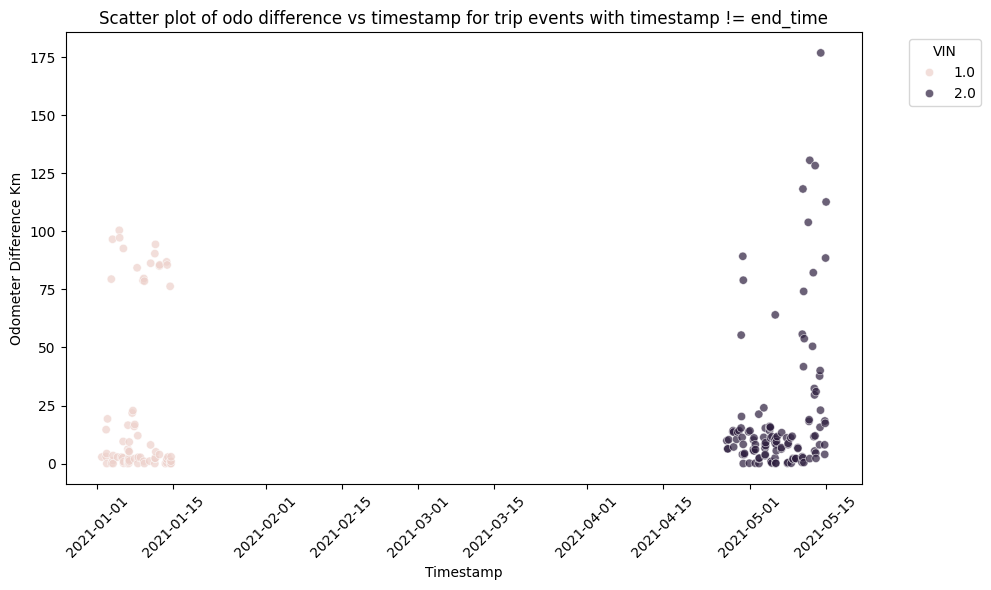

In [37]:

filtered_data = data[(data['event'] == 'trip') & (data['timestamp'] != data['end_time'])].copy()


filtered_data['odo_diff'] = filtered_data['end_odo'] - filtered_data['odo']

# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_data, 
    x='timestamp', 
    y='odo_diff', 
    hue='vin', 
    alpha=0.7
)
plt.title('Scatter plot of odo difference vs timestamp for trip events with timestamp != end_time')
plt.xlabel('Timestamp')
plt.ylabel('Odometer Difference Km')
plt.xticks(rotation=45)
plt.legend(title='VIN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Detect Anomalous Trip Events with SoC Increase

In [38]:
anomalous_rows_trip = data[(data['event'] == 'trip') & (data['end_soc'] > data['soc']) ]
print(f"Number of anamalous rows: {anomalous_rows_trip.shape[0]}")
anomalous_rows_trip.head(len(anomalous_rows_trip ))

Number of anamalous rows: 5


vin           timestamp            end_time          odo      end_odo  \
24   1.0 2021-01-05 17:05:00 2021-01-05 17:12:00  4868.421875  4870.953125   
73   2.0 2021-05-02 16:53:00 2021-05-02 16:57:00  2609.656250  2611.796875   
93   2.0 2021-05-04 22:08:00 2021-05-04 22:12:00  2777.484375  2778.328125   
216  1.0 2021-01-08 11:13:00 2021-01-08 13:23:00  5201.687500  5201.765625   
245  1.0 2021-01-13 19:30:00 2021-01-13 20:46:00  5996.968750  5998.875000   

      soc  end_soc event charge_mode  duration  avg_speed  
24   58.4     58.8  trip           0       7.0  21.696429  
73   33.3     33.7  trip           0       4.0  32.109375  
93   24.3     24.7  trip           0       4.0  12.656250  
216  40.0     40.3  trip           0     130.0   0.036058  
245  50.1     50.9  trip           0      76.0   1.504934

Minimum Diff SoC:  -0.7999999999999972


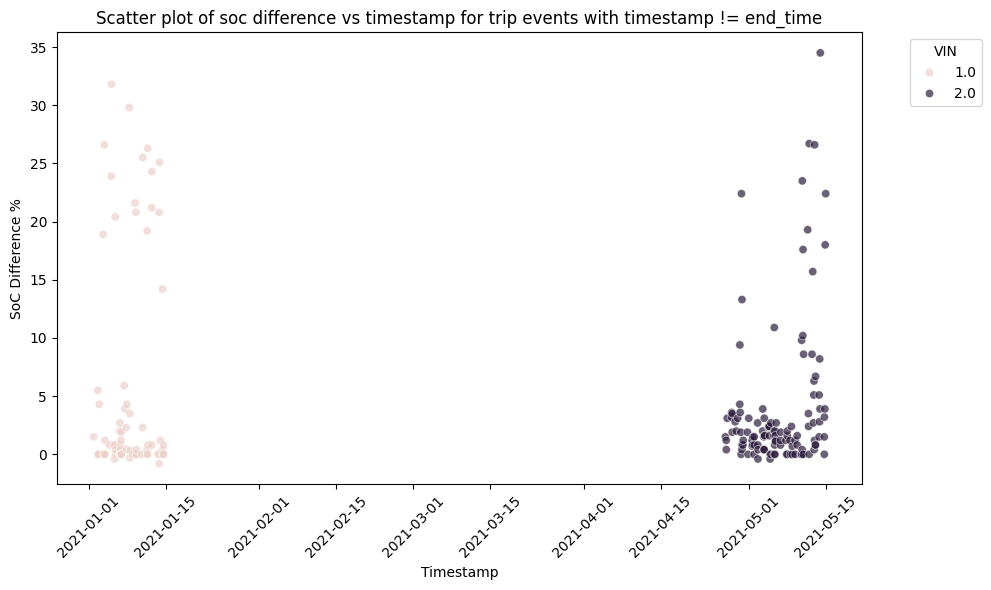

In [39]:

filtered_data = data[(data['event'] == 'trip') & (data['timestamp'] != data['end_time'])].copy()
filtered_data['soc_diff'] = filtered_data['soc'] - filtered_data['end_soc']

print("Minimum Diff SoC: ",filtered_data['soc_diff'].min())
# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_data, 
    x='timestamp', 
    y='soc_diff', 
    hue='vin', 
    alpha=0.7
)
plt.title('Scatter plot of soc difference vs timestamp for trip events with timestamp != end_time')
plt.xlabel('Timestamp')
plt.ylabel('SoC Difference %')
plt.xticks(rotation=45)
plt.legend(title='VIN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Detect Anomalous Trip Events with Odo Decrease

In [40]:
anomalous_rows_trip = data[(data['event'] == 'trip') & (data['end_odo'] < data['odo']) ]
print(f"Number of anamalous rows: {anomalous_rows_trip.shape[0]}")
anomalous_rows_trip.head(len(anomalous_rows_trip ))

Number of anamalous rows: 0


Empty DataFrame
Columns: [vin, timestamp, end_time, odo, end_odo, soc, end_soc, event, charge_mode, duration, avg_speed]
Index: []

### Identify Charge Events with No Charge Despite Time Elapsed

In [41]:
useless_rows_charge = data[(data['event'] == 'charge') & (data['soc'] == data['end_soc'])& (data['timestamp'] != data['end_time'])]
print(f"Number of useless rows: {useless_rows_charge.shape[0]}")
useless_rows_charge.head(len(useless_rows_charge))

Number of useless rows: 3


vin           timestamp            end_time          odo      end_odo  \
21   1.0 2021-01-05 11:57:00 2021-01-05 11:59:00  4868.421875  4868.421875   
136  2.0 2021-05-10 17:54:00 2021-05-10 18:29:00  3083.781250  3083.781250   
162  2.0 2021-05-13 00:13:00 2021-05-13 00:21:00  3869.421875  3869.421875   

      soc  end_soc   event charge_mode  duration  avg_speed  
21   16.0     16.0  charge         240       2.0        0.0  
136  76.0     76.0  charge         120      35.0        0.0  
162  30.1     30.1  charge         120       8.0        0.0

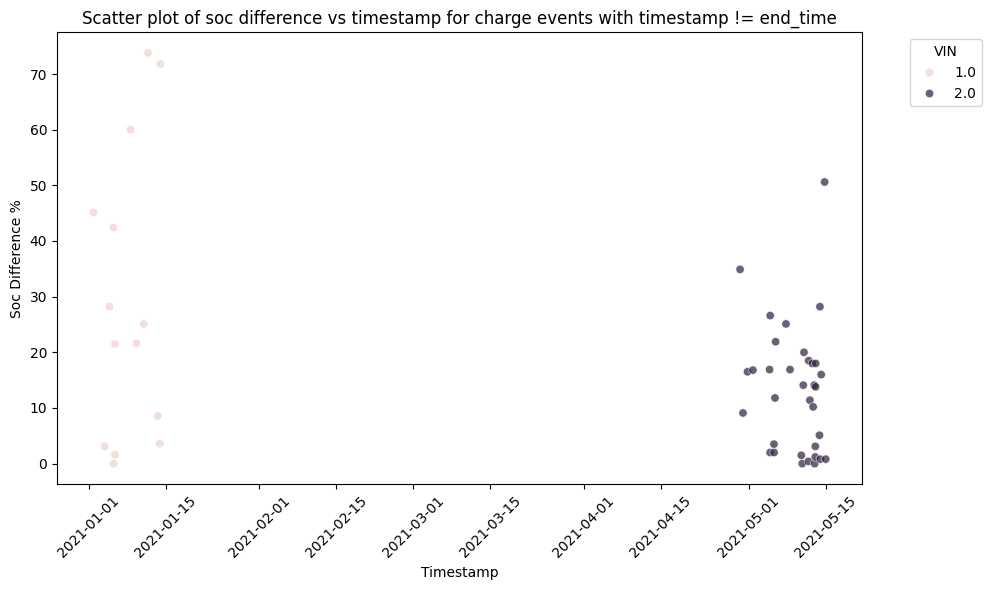

In [42]:

filtered_data = data[(data['event'] == 'charge') & (data['timestamp'] != data['end_time'])].copy()


filtered_data['soc_diff'] = filtered_data['end_soc'] - filtered_data['soc']


plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_data, 
    x='timestamp', 
    y='soc_diff', 
    hue='vin', 
    alpha=0.7
)
plt.title('Scatter plot of soc difference vs timestamp for charge events with timestamp != end_time')
plt.xlabel('Timestamp')
plt.ylabel('Soc Difference %')
plt.xticks(rotation=45)
plt.legend(title='VIN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Detect Anomalous Charge Events with SoC Decrease

In [43]:
anomalows_rows_charge = data[(data['event'] == 'charge') & (data['end_soc'] < data['soc']) ]
print(f"Number of anamalous rows: {anomalows_rows_charge.shape[0]}")
anomalows_rows_charge.head(len(anomalows_rows_charge))

Number of anamalous rows: 0


Empty DataFrame
Columns: [vin, timestamp, end_time, odo, end_odo, soc, end_soc, event, charge_mode, duration, avg_speed]
Index: []

## Discharge Analysis

In [44]:

trip_data = data[data['event'] == 'trip'].copy().reset_index(drop=True)
trip_data['km_driven'] = trip_data['end_odo'] - trip_data['odo']
trip_data['discharge'] = trip_data['soc'] - trip_data['end_soc']
print("📊 Statistics on driven km:\n", trip_data['km_driven'].describe())
print("\n🔋 Statistics on discharge:\n", trip_data['discharge'].describe())
print(trip_data['discharge'])

📊 Statistics on driven km:
 count    196.000000
mean      21.520089
std       32.942740
min        0.000000
25%        2.199219
50%        8.125000
75%       17.582031
max      176.796875
Name: km_driven, dtype: float64

🔋 Statistics on discharge:
 count    196.000000
mean       4.552041
std        7.736033
min       -0.800000
25%        0.000000
50%        1.350000
75%        3.525000
max       34.500000
Name: discharge, dtype: float64
0      1.5
1      0.0
2      5.5
3      0.0
4      0.0
      ... 
191    0.4
192    0.0
193    0.0
194    0.0
195    0.8
Name: discharge, Length: 196, dtype: float64


### Trip Efficiency Analysis: Battery Consumption per Distance and Distance per Battery Unit 

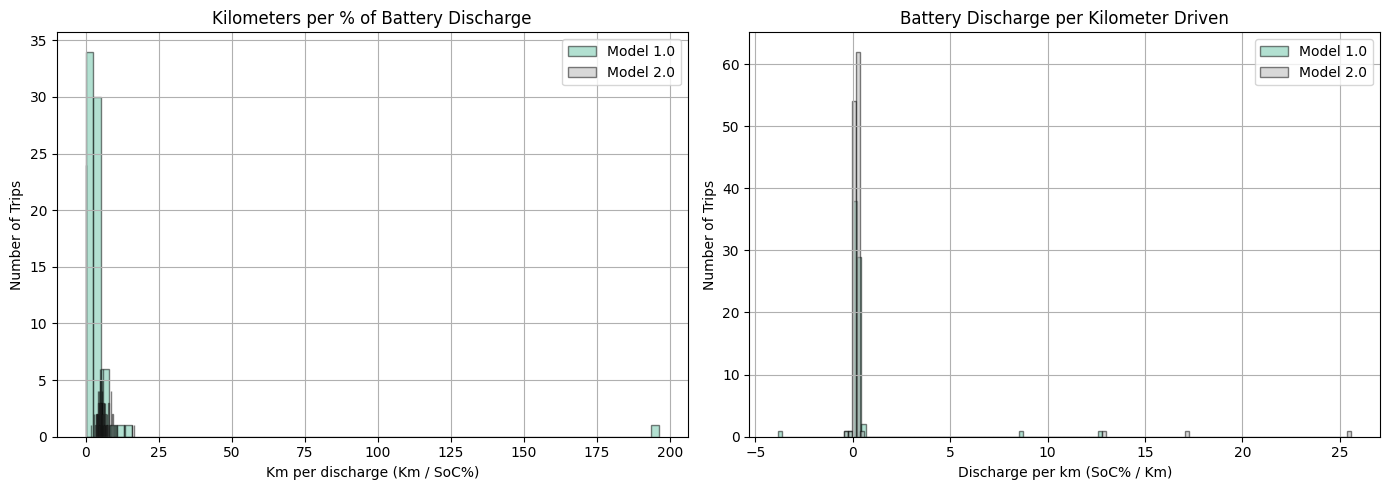

In [45]:

trip_data['km_per_perc_of_battery'] = trip_data.apply(
    lambda row: row['km_driven'] / row['discharge'] if row['discharge'] > 0 else 0,
    axis=1
)

trip_data['discharge_per_km'] = trip_data.apply(
    lambda row: row['discharge'] / row['km_driven'] if row['km_driven'] > 0 else 0,
    axis=1
)

# Setup
models = trip_data['vin'].dropna().unique()
colors = plt.get_cmap('Set2', len(models))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


for i, model in enumerate(models):
    subset = trip_data[trip_data['vin'] == model]
    axes[0].hist(
        subset['km_per_perc_of_battery'],
        bins=len(subset),
        alpha=0.5,
        color=colors(i),
        label=f'Model {model}',
        edgecolor='black'
    )

axes[0].set_title('Kilometers per % of Battery Discharge')
axes[0].set_xlabel('Km per discharge (Km / SoC%)')
axes[0].set_ylabel('Number of Trips')
axes[0].grid(True)
axes[0].legend()

for i, model in enumerate(models):
    subset = trip_data[trip_data['vin'] == model]
    axes[1].hist(
        subset['discharge_per_km'],
        bins=len(subset),
        alpha=0.5,
        color=colors(i),
        label=f'Model {model}',
        edgecolor='black'
    )

axes[1].set_title('Battery Discharge per Kilometer Driven')
axes[1].set_xlabel('Discharge per km (SoC% / Km)')
axes[1].set_ylabel('Number of Trips')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

### Analysis in Driven Km and SoC Discharge

#### Distribution of Trip Distance and Battery Discharge per Vehicle

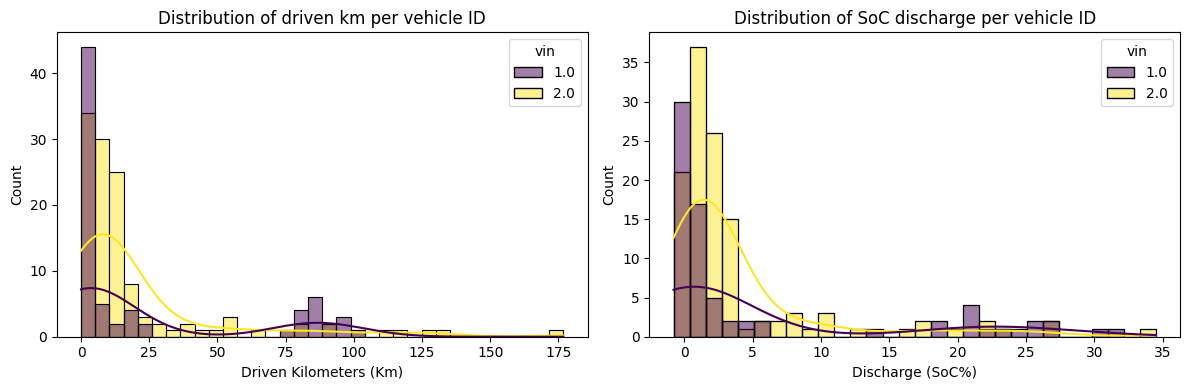

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=trip_data, x='km_driven', kde=True, hue='vin', palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of driven km per vehicle ID')
axes[0].set_xlabel('Driven Kilometers (Km)')

sns.histplot(data=trip_data, x='discharge', kde=True, hue='vin', palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of SoC discharge per vehicle ID')
axes[1].set_xlabel('Discharge (SoC%)')

plt.tight_layout()
plt.show()

#### 3D Density Surface of Kilometers Driven vs SoC Discharge per Vehicle

In [47]:

vehicles = trip_data['vin'].unique()
colors = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges', 'Viridis'] 

fig = go.Figure()

x = trip_data['km_driven'].values
y = trip_data['discharge'].values
xedges = np.linspace(x.min(), x.max(), 31)
yedges = np.linspace(y.min(), y.max(), 31)
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters, indexing="ij")

for i, vin in enumerate(vehicles):
    subset = trip_data[trip_data['vin'] == vin]
    hist, _, _ = np.histogram2d(
        subset['km_driven'], subset['discharge'],
        bins=[xedges, yedges],
        density=True
    )
    
    # Surface plot
    fig.add_trace(go.Surface(
        x=X,
        y=Y,
        z=hist,
        colorscale=colors[i % len(colors)],
        showscale=False,
        name=f'Vehicle {vin}',
        opacity=0.8,
        hoverinfo="skip", 
        legendgroup=f'{vin}', 
        showlegend=True  
    ))

    

fig.update_layout(
    title='3D Histogram Surface of driven km and discharge by each Vehicle',
    scene=dict(
        xaxis_title='Driven Kilometers',
        yaxis_title='Discharge (SoC%)',
        zaxis_title='Density'
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(title="Vehicles")
)

fig.show()

In [48]:


vehicles = trip_data['vin'].unique()
colors = ['Viridis', 'Cividis', 'Plasma', 'Inferno', 'Magma', 'Turbo']


cols = 2
rows = int(np.ceil(len(vehicles) / cols))

fig = make_subplots(
    rows=rows, 
    cols=cols, 
    specs=[[{'type': 'surface'}]*cols for _ in range(rows)],
    subplot_titles=[f'Vehicle {vin}' for vin in vehicles]
)

x = trip_data['km_driven'].values
y = trip_data['discharge'].values
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])

for idx, vin in enumerate(vehicles):
    subset = trip_data[trip_data['vin'] == vin]
    xy_subset = np.vstack([subset['km_driven'].values, subset['discharge'].values])
    kde = gaussian_kde(xy_subset)
    Z = np.reshape(kde(positions).T, X.shape)

    row = idx // cols + 1
    col = idx % cols + 1

    fig.add_trace(
        go.Surface(
            x=X,
            y=Y,
            z=Z,
            colorscale=colors[idx % len(colors)],
            showscale=False,
            opacity=0.8
        ),
        row=row, 
        col=col
    )

fig.update_layout(
    title='3D KDE Surface of driven Km and discharge by Vehicle',
    height=400 * rows,
    width=700 * cols,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

#### 3D Histogram of Driven Kilometers and Battery Discharge

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

divide by zero encountered in matmul

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

overflow encountered in matmul



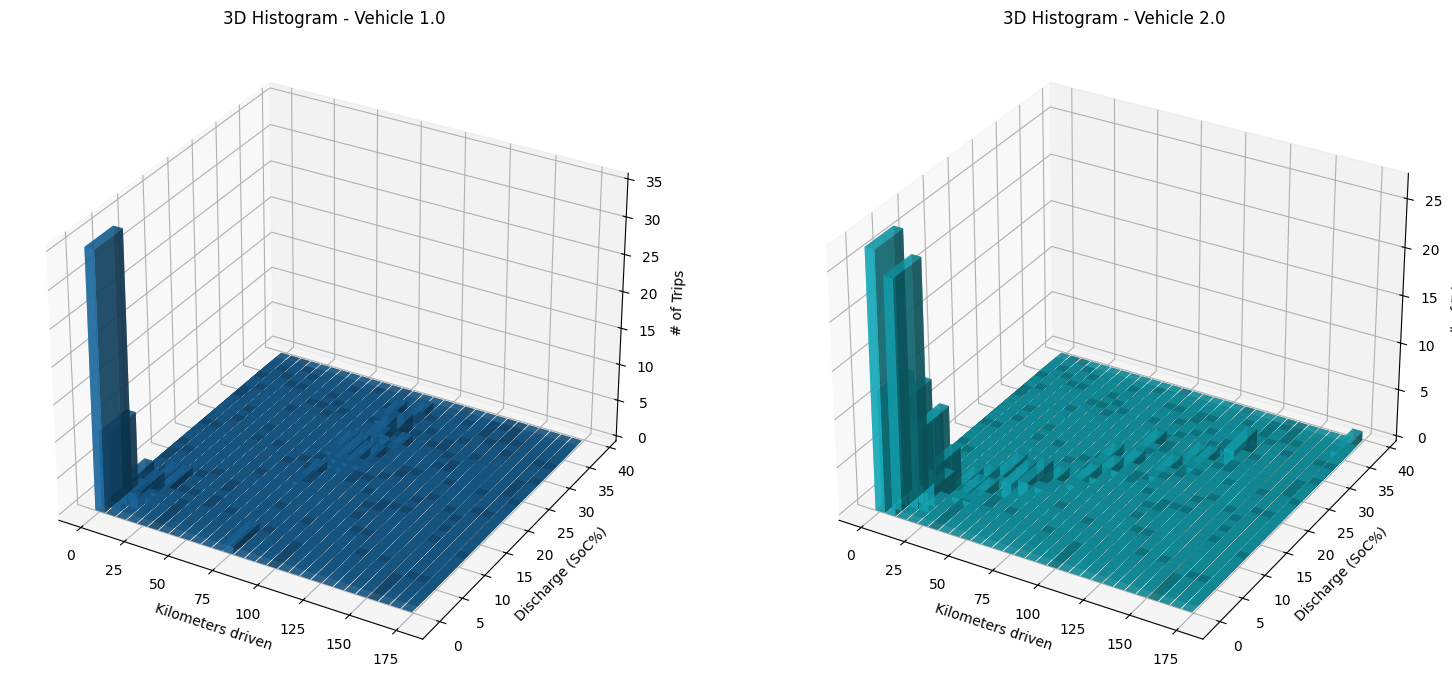

In [49]:

vehicles = trip_data['vin'].unique()[:2]  
colors = plt.get_cmap('tab10', len(vehicles))

fig, axes = plt.subplots(1, 2, figsize=(16, 7), subplot_kw={'projection': '3d'})  # 1 riga, 2 colonne

xedges = np.linspace(trip_data['km_driven'].min(), trip_data['km_driven'].max(), 30)
yedges = np.linspace(trip_data['discharge'].min(), trip_data['discharge'].max(), 30)
dx = dy = (xedges[1] - xedges[0]) * 0.9

for idx, (ax, vin) in enumerate(zip(axes, vehicles)):
    subset = trip_data[trip_data['vin'] == vin]
    hist, _, _ = np.histogram2d(subset['km_driven'], subset['discharge'], bins=[xedges, yedges], density=False)

    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)
    dz = hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors(idx), alpha=0.7, shade=True)
    ax.set_title(f'3D Histogram - Vehicle {vin}')
    ax.set_xlabel('Kilometers driven')
    ax.set_ylabel('Discharge (SoC%)')
    ax.set_zlabel('# of Trips')

plt.tight_layout()
plt.show()

#### Scatter Plot of Battery Discharge vs Kilometers Driven by Vehicle

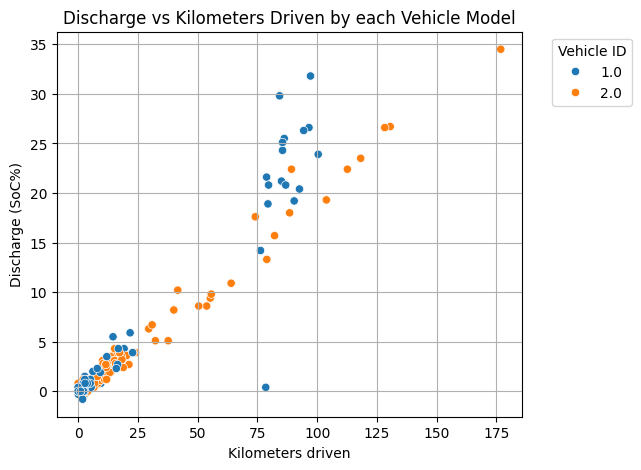

In [50]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=trip_data, x='km_driven', y='discharge',hue = 'vin', palette = 'tab10')
plt.title('Discharge vs Kilometers Driven by each Vehicle Model')
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Kilometers driven')
plt.ylabel('Discharge (SoC%)')
plt.grid(True)
plt.show()

In [51]:
#row of the dataset where the vin 1 has the max km_driven/ discharge
max_km_per_discharge_row = trip_data.loc[trip_data['km_per_perc_of_battery'].idxmax()]
print("Row with max km_per_perc_of_battery:")
print(max_km_per_discharge_row)
#row of the dataset where the vin 1 has the max discharge_per_km

Row with max km_per_perc_of_battery:
vin                                       1.0
timestamp                 2021-01-09 16:09:00
end_time                  2021-01-09 16:16:00
odo                                  5366.875
end_odo                           5445.390625
soc                                      56.8
end_soc                                  56.4
event                                    trip
charge_mode                                 0
duration                                  7.0
avg_speed                          672.991071
km_driven                           78.515625
discharge                                 0.4
km_per_perc_of_battery             196.289063
discharge_per_km                     0.005095
Name: 171, dtype: object


#### Average speed plot

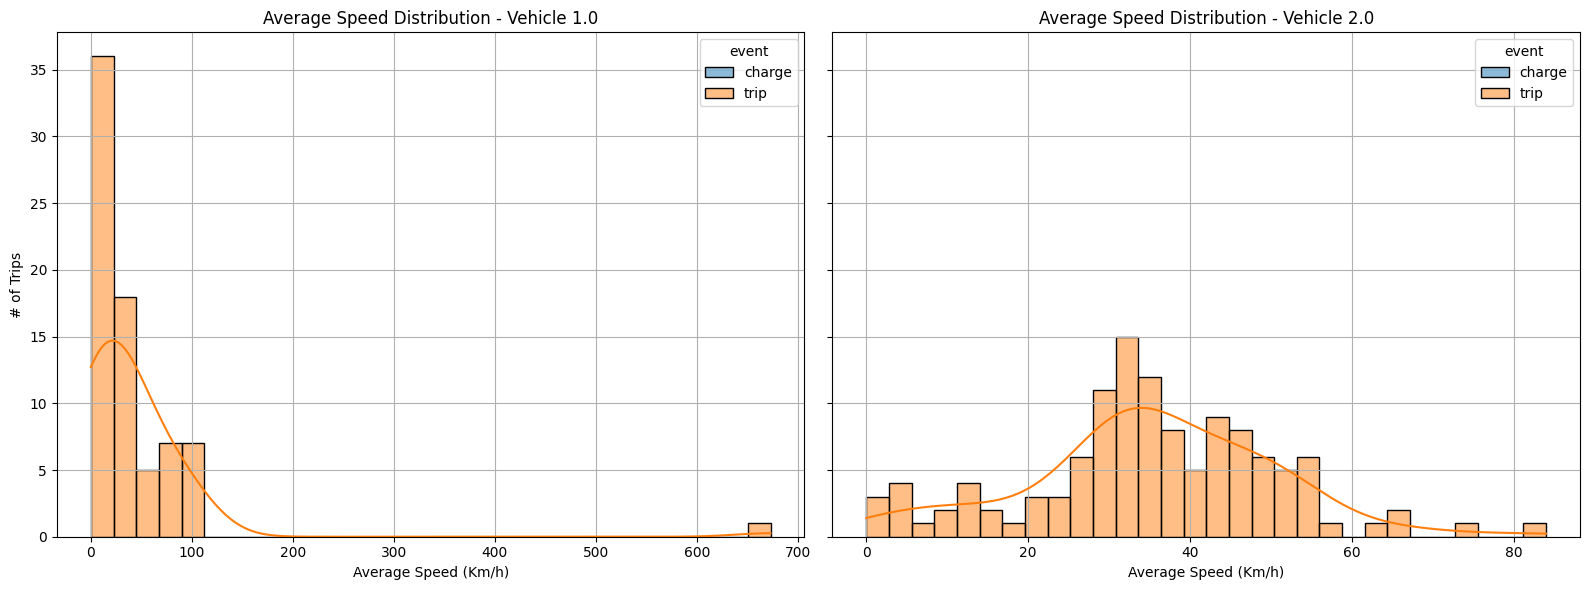

In [52]:
#histogram for average speed
vehicles = trip_data['vin'].dropna().unique()[:2] 
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for ax, vin in zip(axes, vehicles):
    subset = trip_data[trip_data['vin'] == vin]
    sns.histplot(
        data=subset,
        x='avg_speed',
        hue='event',
        multiple='stack',
        kde=True,
        bins=30,
        ax=ax
    )
    ax.set_title(f'Average Speed Distribution - Vehicle {vin}')
    ax.set_xlabel('Average Speed (Km/h)')
    ax.set_ylabel('# of Trips')
    ax.grid(True)
   

plt.tight_layout()
plt.show()


#### Visualize battery discharge across driven distance for each trip

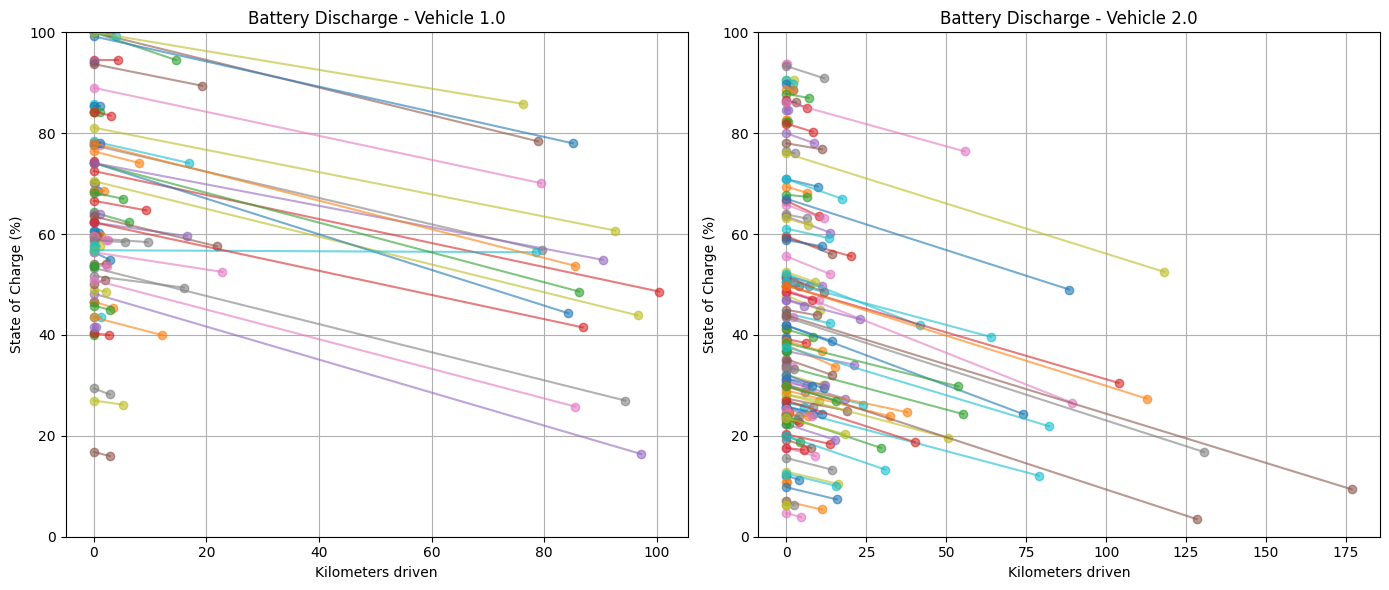

In [53]:


vehicles = trip_data['vin'].unique()[:2]  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

for idx, vin in enumerate(vehicles):
    ax = axes[idx]
    subset = trip_data[trip_data['vin'] == vin]

    for _, row in subset.iterrows():
        x_vals = [0, row['km_driven']]
        y_vals = [row['soc'], row['end_soc']]
        ax.plot(x_vals, y_vals, marker='o', alpha=0.6)

    ax.set_title(f'Battery Discharge - Vehicle {vin}')
    ax.set_xlabel('Kilometers driven')
    ax.set_ylabel('State of Charge (%)')
    ax.set_ylim(0, 100)
    ax.grid(True)

plt.tight_layout()
plt.show()

## Charge Analysis

In [54]:
charge_data = data[data['event'] == 'charge'].copy().reset_index(drop=True)
charge_data['diff_battery'] = charge_data['end_soc'] - charge_data['soc']
charge_data['charge_mode'] = charge_data['charge_mode'].cat.remove_unused_categories()
print("🔋 Statistics on charge km:\n", charge_data['diff_battery'].describe())
print("\n🔍 Categories of the 'charge_mode' column:\n"
    f"{charge_data['charge_mode'].cat.categories.tolist()}")


🔋 Statistics on charge km:
 count    48.000000
mean     17.837500
std      18.149493
min       0.000000
25%       3.100000
50%      15.050000
75%      22.700000
max      73.800000
Name: diff_battery, dtype: float64

🔍 Categories of the 'charge_mode' column:
['120', '240', 'DCCharging']


In [55]:
print("\n🔍 Categories of the 'charge_mode' column:\n"
    f"{charge_data['charge_mode'].cat.categories.tolist()}")


🔍 Categories of the 'charge_mode' column:
['120', '240', 'DCCharging']


### Battery Charge Rate per Vehicle: Distribution of %/min by Charge Mode

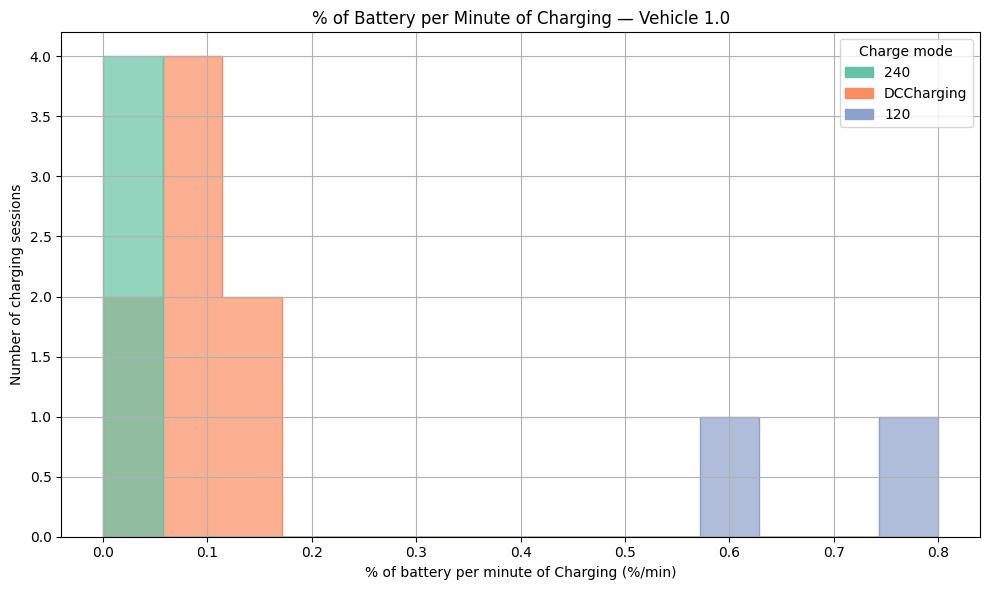

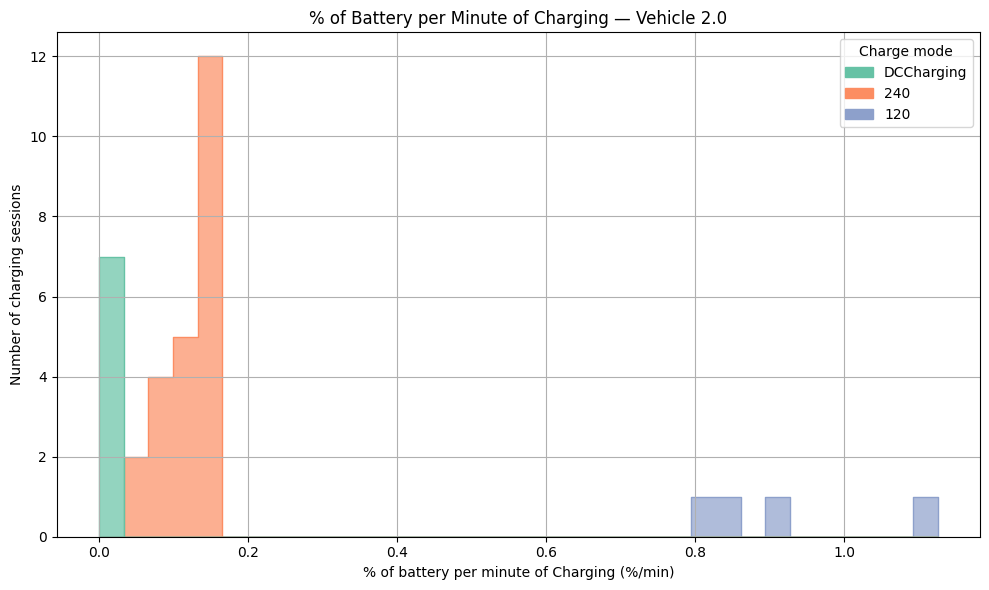

In [56]:
charge_data['perc_per_min'] = charge_data.apply(
    lambda row: row['diff_battery'] / row['duration'] if row['duration'] > 0 else 0,
    axis=1
)

vehicles = charge_data['vin'].dropna().unique()

for vin in vehicles:
    subset = charge_data[charge_data['vin'] == vin]

    if subset.empty:
        continue

    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=subset,
        x='perc_per_min',
        bins=len(subset),
        hue='charge_mode',
        palette='Set2',
        element='step',
        stat='count',
        alpha=0.7
    )
    handles = []
    palette = sns.color_palette('Set2')
    modes = subset['charge_mode'].dropna().unique()

    for i, mode in enumerate(modes):
        color = palette[i % len(palette)]
        patch = mpatches.Patch(color=color, label=mode)
        handles.append(patch)

    plt.title(f'% of Battery per Minute of Charging — Vehicle {vin}')
    plt.xlabel('% of battery per minute of Charging (%/min)')
    plt.ylabel('Number of charging sessions')
    plt.grid(True)
    plt.legend(handles=handles,title='Charge mode')
    plt.tight_layout()
    plt.show()

### Analysis of Vehicle Charging Rates and Density Patterns

#### %SoC per Minute for Each Charging Session

In [57]:
print("\n🔍 Categories of the 'charge_mode' column:\n"
    f"{charge_data['charge_mode'].cat.categories.tolist()}")


🔍 Categories of the 'charge_mode' column:
['120', '240', 'DCCharging']


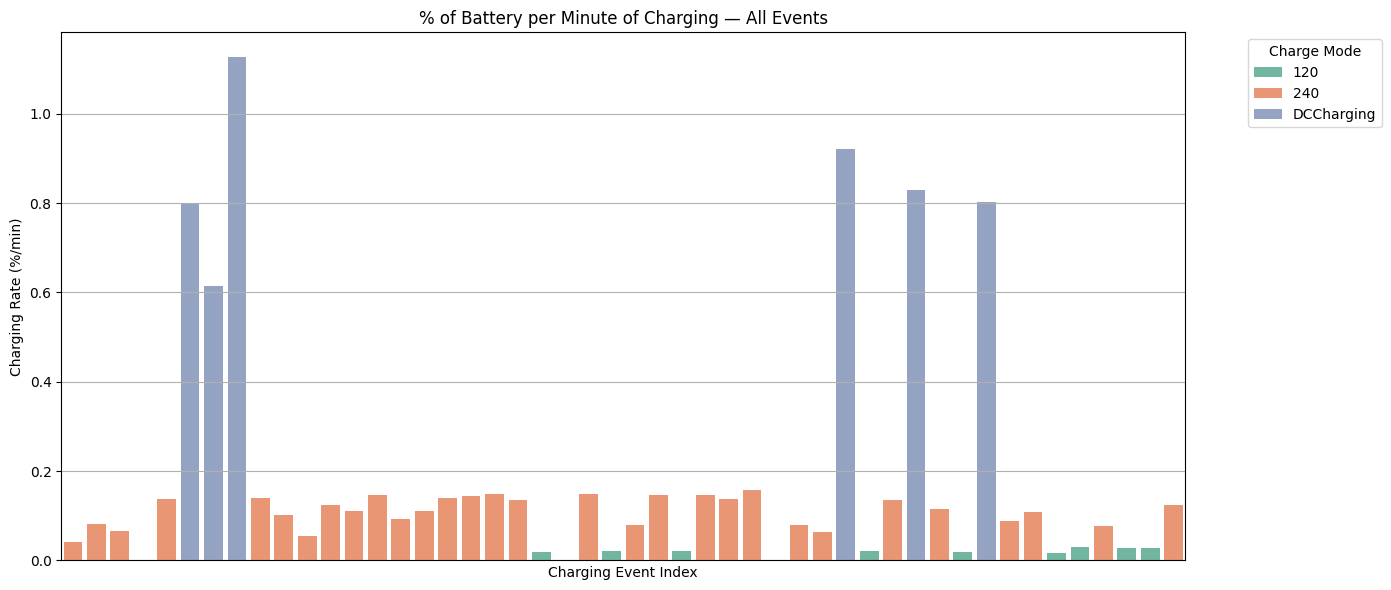

In [58]:
charge_data = charge_data.reset_index(drop=True)
charge_data['event_id'] = charge_data.index

filtered = charge_data[charge_data['duration'] > 0].copy()


filtered['perc_per_min'] = filtered.apply(
    lambda row: row['diff_battery'] / row['duration'] if row['duration'] > 0 else 0,
    axis=1
)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=filtered,
    x='event_id',
    y='perc_per_min',
    hue='charge_mode',
    palette='Set2'
)

plt.title('% of Battery per Minute of Charging — All Events')
plt.xlabel('Charging Event Index')
plt.ylabel('Charging Rate (%/min)')
plt.legend(title='Charge Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([], []) 
plt.grid(True)
plt.tight_layout()
plt.show()

#### 3D KDE Surface Plots of Charging Duration vs Battery State Change for Multiple Vehicles

In [59]:
vehicles = charge_data['vin'].dropna().unique()[:2]
color_sets = [
    pc.sequential.Viridis,
    pc.sequential.Plasma,
    pc.sequential.Cividis,
    pc.sequential.Inferno,
    pc.sequential.Magma,
    pc.sequential.Turbo
]

fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=[f"Vehicle {vin}" for vin in vehicles]
)

for col, vin in enumerate(vehicles, start=1):
    subset_vehicle = charge_data[charge_data['vin'] == vin]
    modes = subset_vehicle['charge_mode'].dropna().unique()

    x = subset_vehicle['duration'].dropna().values
    y = subset_vehicle['diff_battery'].dropna().values
    xgrid = np.linspace(x.min(), x.max(), 100)
    ygrid = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    positions = np.vstack([X.ravel(), Y.ravel()])

    for i, mode in enumerate(modes):
        subset = subset_vehicle[subset_vehicle['charge_mode'] == mode]
        if len(subset) < 2:
            continue
        xy_subset = np.vstack([subset['duration'].values, subset['diff_battery'].values])
        kde = gaussian_kde(xy_subset)
        Z = np.reshape(kde(positions).T, X.shape)

        fig.add_trace(
            go.Surface(
                x=X,
                y=Y,
                z=Z,
                colorscale=color_sets[i % len(color_sets)],
                name=f"{mode} — V{vin}",
                showscale=False,
                opacity=0.8,
                legendgroup=mode,
                showlegend=True,
            ),
            row=1, col=col
        )


fig.update_layout(
    title='3D KDE Surface of Charging Duration vs Battery Difference per Vehicle',
    scene=dict(
        xaxis_title='Duration (min)',
        yaxis_title='Battery difference (SoC%)',
        zaxis_title='Density'
    ),
    scene2=dict(
        xaxis_title='Duration (min)',
        yaxis_title='Battery difference (SoC%)',
        zaxis_title='Density'
    ),
    legend=dict(
        title="Charge Mode",
        itemsizing='constant',
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='black',
        borderwidth=1,
        x=0.85,
        y=0.95
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

#### 3D Histogram of Vehicle Charging Patterns by Mode

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

divide by zero encountered in matmul

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

overflow encountered in matmul



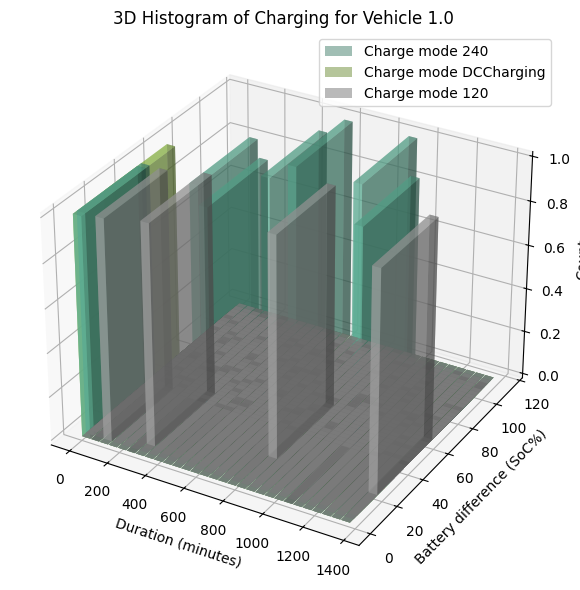

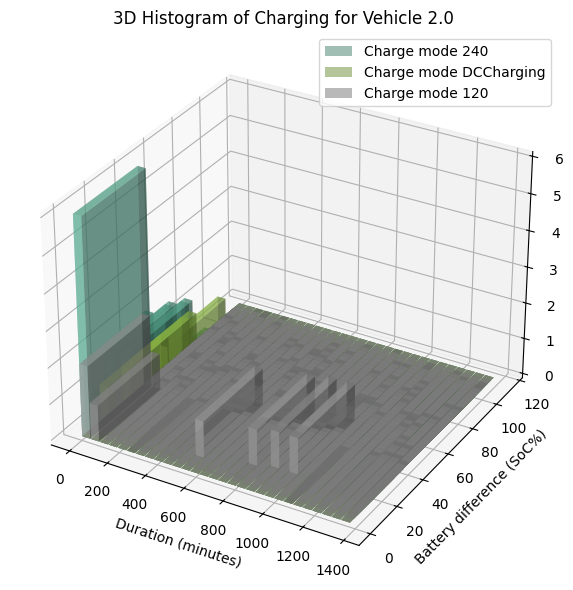

In [60]:
vehicles = charge_data['vin'].dropna().unique()
charge_modes = charge_data['charge_mode'].dropna().unique()
colors = plt.get_cmap('Set2', len(charge_modes))  

x = charge_data['duration'].dropna()
y = charge_data['diff_battery'].dropna()
xedges = np.linspace(x.min(), x.max(), 30)
yedges = np.linspace(y.min(), y.max(), 30)
dx = dy = (xedges[1] - xedges[0]) * 0.9

for vin in vehicles:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    for i, mode in enumerate(charge_modes):
        subset = charge_data[
            (charge_data['vin'] == vin) &
            (charge_data['charge_mode'] == mode)
        ]
        if subset.empty:
            continue

        hist, _, _ = np.histogram2d(
            subset['duration'].dropna(),
            subset['diff_battery'].dropna(),
            bins=[xedges, yedges],
            density=False
        )

        xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
        xpos = xpos.ravel()
        ypos = ypos.ravel()
        zpos = np.zeros_like(xpos)
        dz = hist.ravel()

        ax.bar3d(
            xpos, ypos, zpos,
            dx, dy, dz,
            color=colors(i),
            alpha=0.5,  
            label=f'Charge mode {mode}',
            shade=True
        )

    ax.set_xlabel('Duration (minutes)')
    ax.set_ylabel('Battery difference (SoC%)')
    ax.set_zlabel('Count')
    ax.set_title(f'3D Histogram of Charging for Vehicle {vin}')
    ax.legend()
    plt.tight_layout()
    plt.show()

#### Battery Charge Progression by Charge Mode per Vehicle

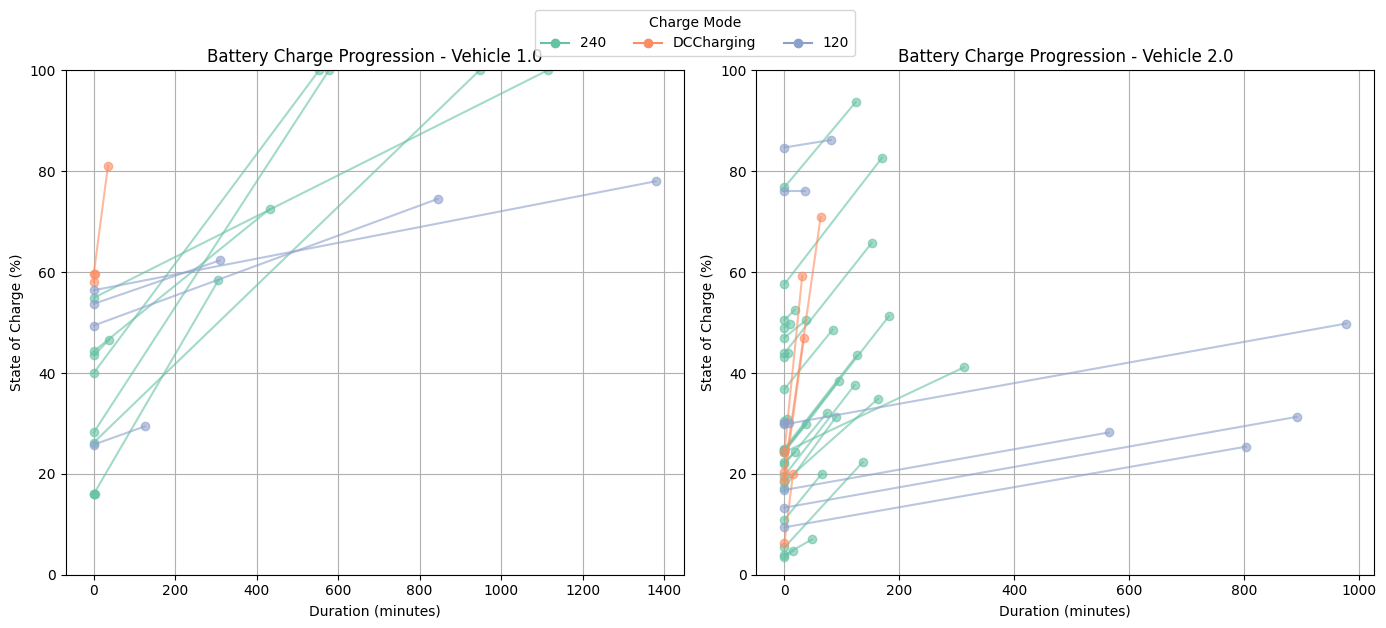

In [61]:
from matplotlib.lines import Line2D
vehicles = charge_data['vin'].dropna().unique()[:2]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
charge_modes = charge_data['charge_mode'].dropna().unique()
palette = sns.color_palette('Set2', len(charge_modes))
mode_to_color = {mode: palette[i] for i, mode in enumerate(charge_modes)}

for idx, vin in enumerate(vehicles):
    ax = axes[idx]
    subset = charge_data[charge_data['vin'] == vin]

    for mode in charge_modes:
        mode_subset = subset[subset['charge_mode'] == mode]
        for _, row in mode_subset.iterrows():
            x_vals = [0, row['duration']]
            y_vals = [row['soc'], row['end_soc']]
            ax.plot(x_vals, y_vals, marker='o', alpha=0.6, color=mode_to_color[mode])

    ax.set_title(f'Battery Charge Progression - Vehicle {vin}')
    ax.set_xlabel('Duration (minutes)')
    ax.set_ylabel('State of Charge (%)')
    ax.set_ylim(0, 100)
    ax.grid(True)


handles = [Line2D([0], [0], color=mode_to_color[mode], label=mode, marker='o', linestyle='-') for mode in charge_modes]
fig.legend(handles=handles, title='Charge Mode', loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(charge_modes))

plt.tight_layout()
plt.show()

## Event timeline

In [62]:
data['event_id'] = range(1, len(data) + 1)
first_data = data['timestamp'].min() 
last_data = data['end_time'].max()

In [63]:
def event_label(row):
    if row['event'] == 'trip':
        return 'trip'
    elif row['event'] == 'charge' and str(row['charge_mode']) == '240':
        return 'charge_240'
    elif row['event'] == 'charge' and str(row['charge_mode']) == 'DCCharging':
        return 'charge_DC'
    elif row['event'] == 'charge' and str(row['charge_mode']) == '120':
        return 'charge_120'
    else:
        return 'ignore'
color_map = {
    'trip': "#ff0000",
    'charge_240': "#b2fc62",
    'charge_DC': "#004af7",
    'charge_120': "#9400f7"
}


legend_labels = {
    'trip': 'Trip',
    'charge_240': 'Charge (240V)',
    'charge_DC': 'Charge (DC)',
    'charge_120': 'Charge (120V)'
}


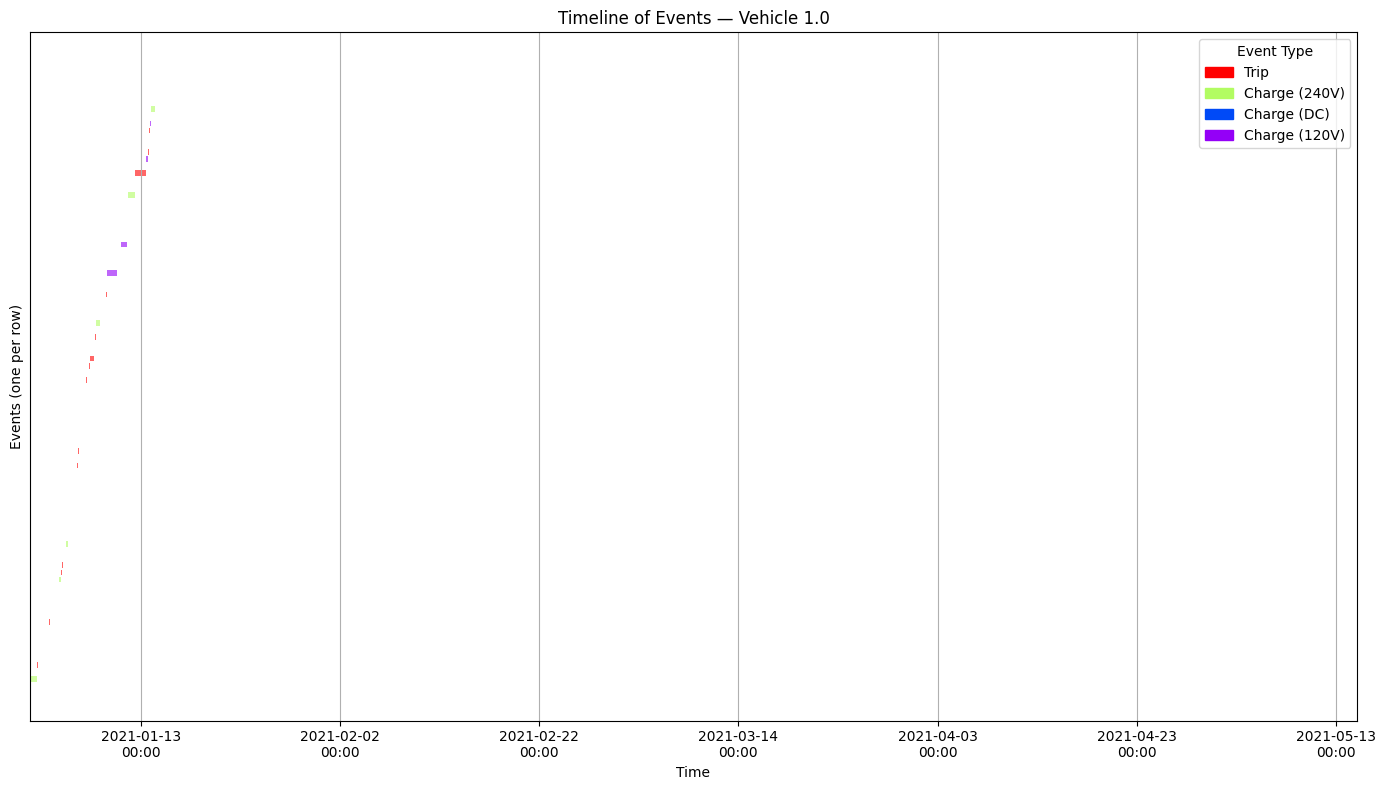

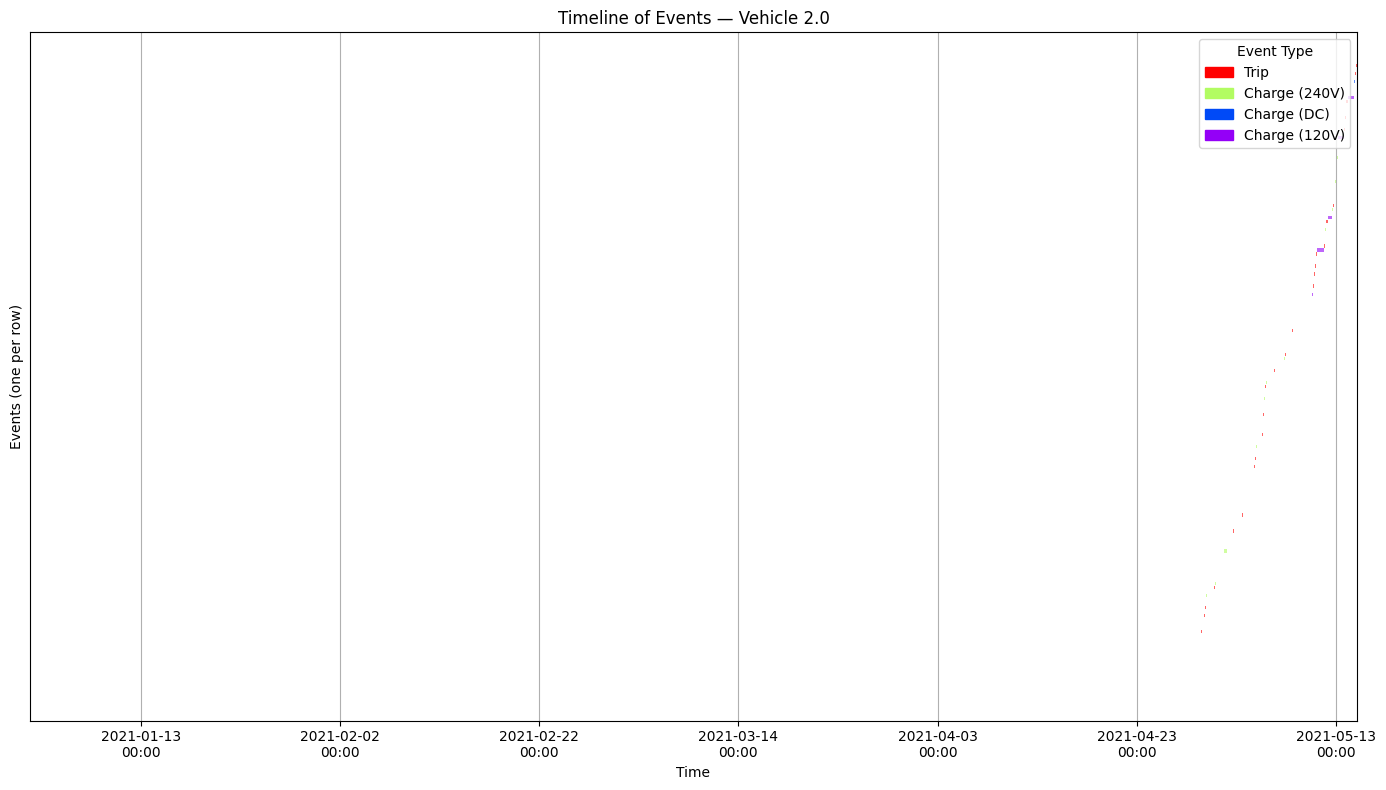

In [64]:
vehicles = data['vin'].dropna().unique()

for vin in vehicles:
    fig, ax = plt.subplots(figsize=(14, 8))
    subset = data[data['vin'] == vin].sort_values(by='timestamp').reset_index(drop=True)

    y_offset = 0
    bar_height = 8

    for _, row in subset.iterrows():
        event_type = event_label(row)
        if event_type == 'ignore':
            continue  

        start = mdates.date2num(row['timestamp'])
        end = mdates.date2num(row['end_time'])
        duration = end - start
        color = color_map.get(event_type, 'gray')

        ax.broken_barh(
            [(start, duration)],
            (y_offset, bar_height),
            facecolors=color,
            alpha=0.6
        )
        y_offset += bar_height + 2

    
    ax.set_xlim(mdates.date2num(first_data), mdates.date2num(last_data))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax.set_xlabel('Time')
    ax.set_ylabel('Events (one per row)')
    ax.set_title(f'Timeline of Events — Vehicle {vin}')
    ax.grid(True)
    ax.set_yticks([])


    legend_patches = [mpatches.Patch(color=color_map[k], label=v) for k, v in legend_labels.items()]
    ax.legend(handles=legend_patches, title='Event Type', loc='upper right')

    plt.tight_layout()
    plt.show()

In [65]:
import plotly.graph_objects as go
import pandas as pd

data['timestamp'] = pd.to_datetime(data['timestamp'])
data['end_time'] = pd.to_datetime(data['end_time'])
data['event_id'] = range(1, len(data) + 1)





vehicles = data['vin'].dropna().unique()
for vin in vehicles:
    subset = data[data['vin'] == vin].sort_values(by='timestamp').reset_index(drop=True)

    fig = go.Figure()

    for i, row in subset.iterrows():
        event_type = event_label(row)
        if event_type == 'ignore':
            continue


        fig.add_trace(go.Scatter(
            x=[row['timestamp'], row['end_time']],
            y=[i, i],
            mode='lines+markers',
            line=dict(color=color_map[event_type], width=10),
            marker=dict(color=color_map[event_type], size=12),
            name=legend_labels[event_type],
            hovertemplate=f"ID: {row['event_id']}<br>Type: {legend_labels[event_type]}<br>Start: {row['timestamp']}<br>End: {row['end_time']}<extra></extra>",
            showlegend=not any(t.name == legend_labels[event_type] for t in fig.data)
        ))

    fig.update_layout(
        title=f"Interactive Timeline of Events — Vehicle {vin}",
        xaxis_title="Time",
        yaxis_title="Event Index",
        yaxis=dict(autorange="reversed", tickmode='linear'),
        height=600,
        legend_title="Event Type",
        xaxis=dict(
            type='date',
            tickformatstops=[
                dict(dtickrange=[None, 1000 * 60 * 60 * 24], value="%H:%M"),
                dict(dtickrange=[1000 * 60 * 60 * 24, 1000 * 60 * 60 * 24 * 7], value="%d %b"),
                dict(dtickrange=[1000 * 60 * 60 * 24 * 7, None], value="%b %Y")
            ]
        )
    )

    fig.show()

### Analysis of Overlapping Events

In [66]:

overlapping_events = []
for vm, group in data.sort_values(by='timestamp').groupby('vin'):
    group = group.sort_values(by='timestamp').reset_index(drop=True)
    
    for i in range(1, len(group)):
        prev_end = group.loc[i - 1, 'end_time']
        curr_start = group.loc[i, 'timestamp']
        
        if pd.notna(prev_end) and pd.notna(curr_start) and curr_start < prev_end:
            overlapping_events.append({
                'vehicle': vm,
                'prev_event_id': group.loc[i - 1, 'event_id'],
                'curr_event_id': group.loc[i, 'event_id'],
                'prev_end': prev_end,
                'curr_start': curr_start
            })


overlap_df = pd.DataFrame(overlapping_events)
print(f"🔍 Found {len(overlap_df)} overlapping event pairs.\n")
print(overlap_df)

🔍 Found 0 overlapping event pairs.

Empty DataFrame
Columns: []
Index: []


In [67]:
data.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_preprocessed.csv', index=False)

# OneHotEncoder

In [68]:
ohe = OneHotEncoder(handle_unknown='ignore')
# Fit the one-hot encoder on training data
cols_to_convert = ['event', 'charge_mode']
ohe.fit(data[cols_to_convert])
# Create a new DataFrame with only the one-hot encoded columns
temp_data = pd.DataFrame(data=ohe.transform(data[cols_to_convert]).toarray(),
                             columns=ohe.get_feature_names_out())
# Create a copy of the DataFrame
data_encoded = data.copy()

# Remove the old categorical columns from the original data
data_encoded.drop(columns=cols_to_convert, axis=1, inplace=True)
data_encoded = pd.concat([data_encoded.reset_index(drop=True), temp_data], axis=1)


In [69]:
data_encoded.drop(columns=['charge_mode_0'], axis=1, inplace=True)
data_encoded.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.46875   
2  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
3  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
4  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   

     soc  end_soc  duration  avg_speed  event_id  event_charge  event_trip  \
0   56.4     54.9       7.0  24.241071         1           0.0         1.0   
1   54.9    100.0    1114.0   0.000000         2           1.0         0.0   
2  100.0    100.0       8.0  22.734375         3           0.0         1.0   
3  100.0     94.5     145.0   6.051724         4           0.0         1.0   
4   94.5     94.5       7.0  37.071429         5           0.0         1.0   

   charge_mode_120  charge_mode_240  charge_mode_DCCharging  
0              0.0              0.0                     0.0  
1              0.0              1.0                     0.0  
2              0.0              0.0                     0.0  
3              0.0              0.0                     0.0  
4              0.0              0.0                     0.0

In [70]:
#selecting numerical columns
cols_to_exclude = ['vin', 'event_id']
numerical_cols = data_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]


# Selecting only numerical columns for correlation
numerical_data = data_encoded[numerical_cols]
vehicles = data_encoded['vin'].unique()


### Feature Correlation Heatmap

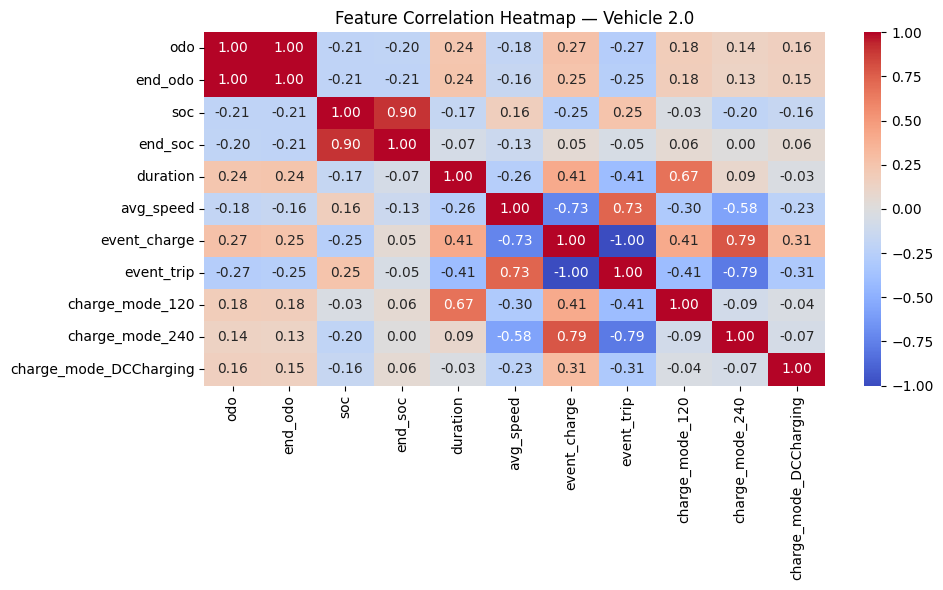

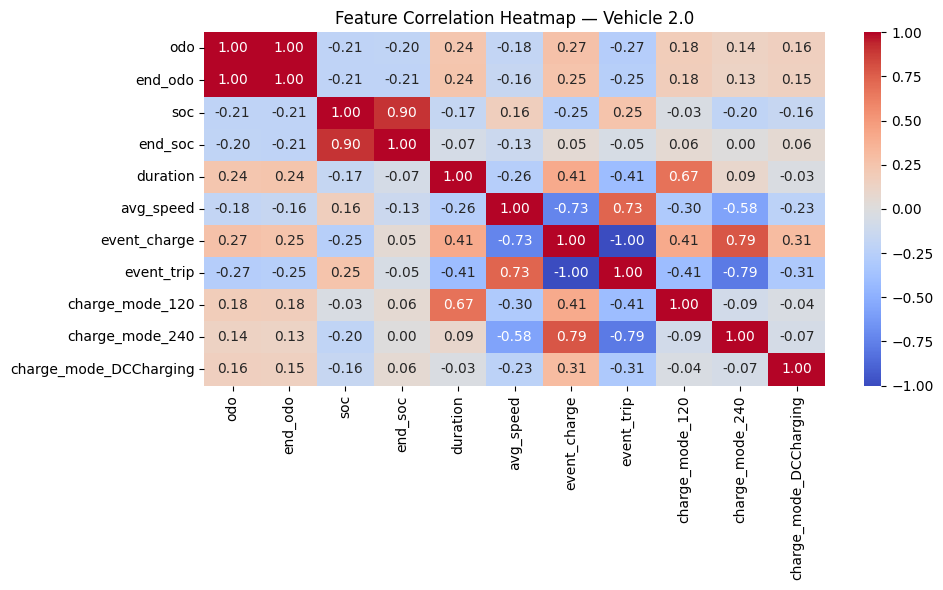

In [71]:
for vehicle in vehicles:
    subset = data_encoded[data_encoded['vin'] == vin]

    numerical_data = subset[numerical_cols]

    if numerical_data.shape[0] < 2:
        continue 

    corr = numerical_data.corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Heatmap — Vehicle {vin}')
    plt.tight_layout()
    plt.show()

In [72]:
data_encoded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_OHE.csv', index=False)

# 2D Embedding

In [73]:
data_embedded = data.copy()

In [74]:
data_embedded.info()


<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 0 to 255
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          244 non-null    float64       
 1   timestamp    244 non-null    datetime64[ns]
 2   end_time     244 non-null    datetime64[ns]
 3   odo          244 non-null    float64       
 4   end_odo      244 non-null    float64       
 5   soc          244 non-null    float64       
 6   end_soc      244 non-null    float64       
 7   event        244 non-null    category      
 8   charge_mode  244 non-null    category      
 9   duration     244 non-null    float64       
 10  avg_speed    244 non-null    float64       
 11  event_id     244 non-null    int64         
dtypes: category(2), datetime64[ns](2), float64(7), int64(1)
memory usage: 21.8 KB


In [75]:
data_embedded.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.46875   
2  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
3  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
4  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   

     soc  end_soc   event charge_mode  duration  avg_speed  event_id  
0   56.4     54.9    trip           0       7.0  24.241071         1  
1   54.9    100.0  charge         240    1114.0   0.000000         2  
2  100.0    100.0    trip           0       8.0  22.734375         3  
3  100.0     94.5    trip           0     145.0   6.051724         4  
4   94.5     94.5    trip           0       7.0  37.071429         5

In [76]:
# === EMBEDDING PREPARATION ===
import torch
label_encoders = {}
cat_indices = {}
for col in cols_to_convert:
    le = LabelEncoder()
    cat_indices[col + "_idx"] = le.fit_transform(data_embedded[col].astype(str))
    label_encoders[col] = le

data_cat_idx = pd.DataFrame(cat_indices)
X_cat = torch.tensor(data_cat_idx.values, dtype=torch.long)

num_classes_per_cat = [len(label_encoders[col].classes_) for col in cols_to_convert]
embedding_dims = [2 for _ in num_classes_per_cat] 

embedding_layers = nn.ModuleList([
    nn.Embedding(num_embeddings=n, embedding_dim=d)
    for n, d in zip(num_classes_per_cat, embedding_dims)
])


embedded_parts = [embedding_layers[i](X_cat[:, i]) for i in range(X_cat.shape[1])]
embedded_features = torch.cat(embedded_parts, dim=1)  # [num_samples, total_emb_dim]

embedded_feature_names = []
for col, dim in zip(cols_to_convert, embedding_dims):
    embedded_feature_names.extend([f"{col}_emb_{i}" for i in range(dim)])

df_embedded = pd.DataFrame(embedded_features.detach().numpy(), columns=embedded_feature_names)



data_noncat = data_embedded.drop(columns=cols_to_convert).reset_index(drop=True)

data_embedded = pd.concat([data_noncat, df_embedded], axis=1)

In [77]:
data_embedded.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.46875   
2  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
3  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
4  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   

     soc  end_soc  duration  avg_speed  event_id  event_emb_0  event_emb_1  \
0   56.4     54.9       7.0  24.241071         1     1.384524     0.498406   
1   54.9    100.0    1114.0   0.000000         2     1.732660     0.662151   
2  100.0    100.0       8.0  22.734375         3     1.384524     0.498406   
3  100.0     94.5     145.0   6.051724         4     1.384524     0.498406   
4   94.5     94.5       7.0  37.071429         5     1.384524     0.498406   

   charge_mode_emb_0  charge_mode_emb_1  
0           0.113223          -1.172877  
1          -0.281733          -0.592711  
2           0.113223          -1.172877  
3           0.113223          -1.172877  
4           0.113223          -1.172877

In [78]:
cols_to_convert = ['event_emb_0','event_emb_1', 'charge_mode_emb_0', 'charge_mode_emb_1']
data_embedded[cols_to_convert] = data_embedded[cols_to_convert].astype('float64')
data_embedded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   vin                244 non-null    float64       
 1   timestamp          244 non-null    datetime64[ns]
 2   end_time           244 non-null    datetime64[ns]
 3   odo                244 non-null    float64       
 4   end_odo            244 non-null    float64       
 5   soc                244 non-null    float64       
 6   end_soc            244 non-null    float64       
 7   duration           244 non-null    float64       
 8   avg_speed          244 non-null    float64       
 9   event_id           244 non-null    int64         
 10  event_emb_0        244 non-null    float64       
 11  event_emb_1        244 non-null    float64       
 12  charge_mode_emb_0  244 non-null    float64       
 13  charge_mode_emb_1  244 non-null    float64       
dtypes: datetim

In [79]:
data_embedded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_2DE.csv', index=False)

### Timestamp Normalization to Hours Since Start

In [80]:
#select the least recent date in timestamp
min_date = data_embedded['timestamp'].min()
#compute the difference in hour from the minimum date
data_embedded['timestamp'] = (data_embedded['timestamp'] - min_date).dt.total_seconds() / 3600
data_embedded['end_time'] = (data_embedded['end_time'] - min_date).dt.total_seconds() / 3600

In [81]:
#selecting numerical columns
cols_to_exclude = ['vin', 'event_id']
numerical_cols = data_embedded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]

# Selecting only numerical columns for correlation
numerical_data = data_embedded[numerical_cols]
vehicles = data_embedded['vin'].unique()

### Feature Correlation Heatmap

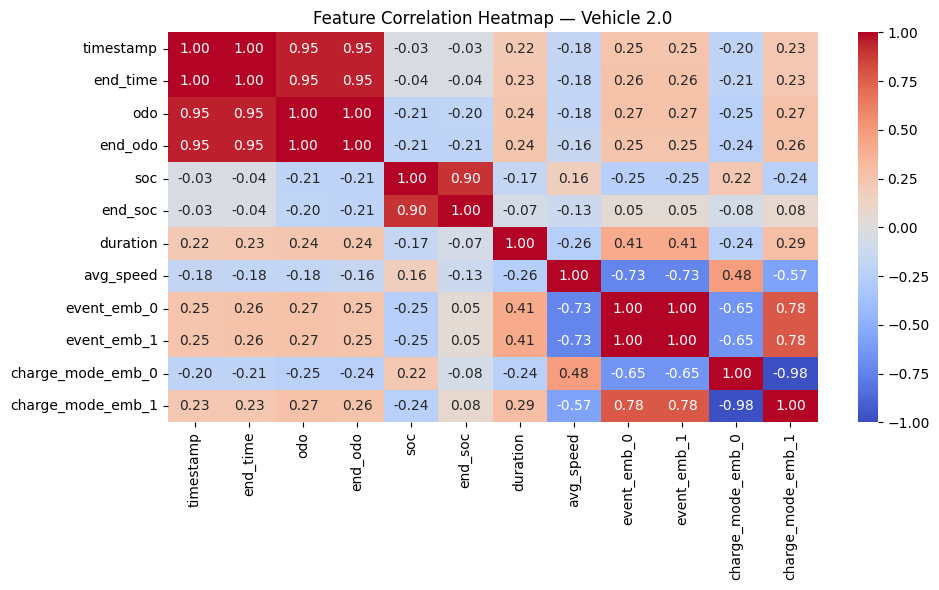

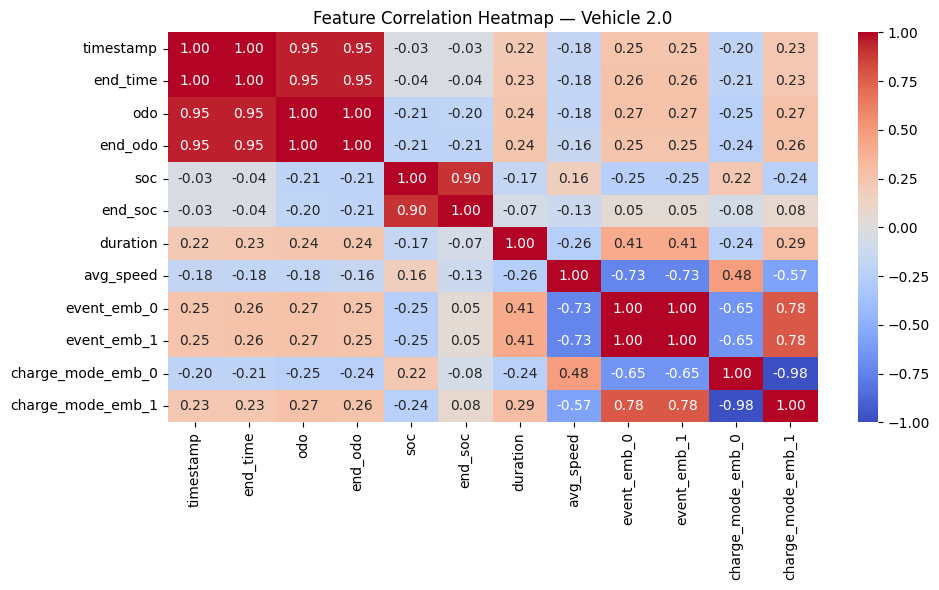

In [82]:
for vehicle in vehicles:
    subset = data_embedded[data_encoded['vin'] == vin]

    numerical_data = subset[numerical_cols]

    if numerical_data.shape[0] < 2:
        continue 

    corr = numerical_data.corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Heatmap — Vehicle {vin}')
    plt.tight_layout()
    plt.show()


In [83]:
data_embedded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_2DE_time_norm.csv', index=False)

In [84]:

data_embedded['event'] = label_encoders['event'].inverse_transform(data_cat_idx['event_idx'])
data_embedded['charge_mode'] = label_encoders['charge_mode'].inverse_transform(data_cat_idx['charge_mode_idx'])


data_from_2DE_to_original = data_embedded.drop(columns=[
    'event_emb_0', 'event_emb_1',
    'charge_mode_emb_0', 'charge_mode_emb_1'
])

In [85]:
data_from_2DE_to_original.head()

vin  timestamp   end_time          odo     end_odo    soc  end_soc  \
0  1.0   0.000000   0.116667  4436.640625  4439.46875   56.4     54.9   
1  1.0   0.133333  18.700000  4439.468750  4439.46875   54.9    100.0   
2  1.0  18.700000  18.833333  4439.468750  4442.50000  100.0    100.0   
3  1.0  18.833333  21.250000  4442.500000  4457.12500  100.0     94.5   
4  1.0  21.250000  21.366667  4457.125000  4461.45000   94.5     94.5   

   duration  avg_speed  event_id   event charge_mode  
0       7.0  24.241071         1    trip           0  
1    1114.0   0.000000         2  charge         240  
2       8.0  22.734375         3    trip           0  
3     145.0   6.051724         4    trip           0  
4       7.0  37.071429         5    trip           0

In [86]:
cols_to_convert = ['event', 'charge_mode']
for col in cols_to_convert:
    data_from_2DE_to_original[col] = data_from_2DE_to_original[col].astype('category')
data_from_2DE_to_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   vin          244 non-null    float64 
 1   timestamp    244 non-null    float64 
 2   end_time     244 non-null    float64 
 3   odo          244 non-null    float64 
 4   end_odo      244 non-null    float64 
 5   soc          244 non-null    float64 
 6   end_soc      244 non-null    float64 
 7   duration     244 non-null    float64 
 8   avg_speed    244 non-null    float64 
 9   event_id     244 non-null    int64   
 10  event        244 non-null    category
 11  charge_mode  244 non-null    category
dtypes: category(2), float64(9), int64(1)
memory usage: 20.0 KB
